In [ ]:
'''
Dynamic pricing - curtailment_rate (19x16)
PAR ----
priorities ----
'''

'\nDynamic pricing - curtailment_rate (19x16)\nPAR ----\npriorities ----\n'

In [ ]:
#imports
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
load_df = pd.read_csv("/content/drive/MyDrive/dataset/load_characteristics.csv")
curtailment_df = pd.read_csv("/content/drive/MyDrive/dataset/required_curtailment.csv")

In [ ]:
load_df

,IL No,Capacity,Rate,Max_off,Min_on
0,1,320,23.8,4,2
1,2,200,25.7,4,2
2,3,80,16.9,4,2
3,4,84,16.9,4,2
4,5,100,19.2,4,2
5,6,160,23.6,4,2
6,7,100,19.2,3,1
7,8,60,16.9,3,1
8,9,200,25.7,3,1
9,10,40,16.9,4,1


In [ ]:
capacities = list(load_df["Capacity"])
curtailment_rate = list(load_df["Rate"])

In [ ]:
curtailment_df

,Hour,curtailment_A,curtailment_B
0,1,0,113.8
1,2,0,227.5
2,3,0,455.0
3,4,0,682.5
4,5,444,773.5
5,6,430,796.3
6,7,436,750.8
7,8,0,637.0
8,9,336,591.5
9,10,797,609.7


In [ ]:
priority = np.array([1, 1, 2, 2, 3, 1, 2, 3, 2, 3, 2, 2, 3, 1, 1, 3, 3, 1, 1])
print(priority.shape)

(19,)


In [ ]:
curtailment_A = np.array(curtailment_df["curtailment_A"])

In [ ]:
curtailment_B = np.array(curtailment_df["curtailment_B"])

In [ ]:
Max_off = np.array(load_df["Max_off"])
Min_on = np.array(load_df["Min_on"])

In [ ]:
'''
SEPARATE EXCESS AND UNDER CURTAILMENT
'''

def fitness_func(p, N, T, capacity, curtailment_rate):
  sch = p.x
  s1 = 0
  curtailment_count = np.zeros(N)
  UC = 0

  for t in range(T):

    hour_curtailment = 0
    curtailment_count = np.add(curtailment_count , np.array(sch[t]))

    for n in range(N):
      s1 += sch[t][n]*capacity[n]*curtailment_rate[n]*(4-priority[n])
      hour_curtailment += capacity[n]*sch[t][n]

    if hour_curtailment < curtailment_A[t]:
      UC += 1

  curtailment_count = curtailment_count.astype(int).tolist()

  curtailment_freq = [0 for _ in range(T+1)]

  for c in curtailment_count:
    for j in range(c+1):
      curtailment_freq[j] += 1

  s2 = 0
  for i in range(2, T+1):
    s2 += (2**(i-2))*curtailment_freq[i]


  s2 *= 1000

  UC *= 10000000

  #Implement PAR -----------------------

  peak_load = -float("inf")
  avg_load = 0

  for i in range(T):
    hourly_load = 0

    for j in range(N):
      if sch[i][j] == 0:
        hourly_load += capacity[n]

    if hourly_load > peak_load:
      peak_load = hourly_load

    avg_load += hourly_load

  avg_load /= T
  avg_load += 1

  PAR = 10000*(peak_load/avg_load)

  # -----------------------------------



  # ADDITIONAL CONSTRAINTS IMPLEMENTATION

  over = 0
  under = 0

  for i in range(N):
    off_hours = curtailment_count[i]
    on_hours = T-off_hours

    if off_hours > Max_off[i]:
      over += off_hours - Max_off[i]

    if on_hours < Min_on[i]:
      under += Min_on[i] - on_hours

  over *= 100000
  under *= 1000
  return -(s1 + s2 + UC + over + under)

In [ ]:
class Particle:
  def __init__(self, n, t, id = None, show_update=False):

    self.show_update = show_update
    self.id = id
    self.n = n
    self.t = t
    self.x = np.array([[random.choice([0,1]) for _ in range(self.n)] for __ in range(t)])
    self.v = np.array([[random.uniform(-5, 5) for _ in range(self.n)] for __ in range(t)]).astype('float64')
    self.fitness = fitness_func(self, self.n, self.t, capacities, curtailment_rate)

    self.p_best = self.x.copy()
    self.p_best_fitness = self.fitness

  def update_vel_pos(self, G_best_x):
    inertia = 1
    cognitive_coeff = 7.5
    social_coeff = 7.5
    v_max = 5
    threshold = random.random()
    # print(self.v.dtype)

    r1 = np.random.random((16, 19))
    r2 = np.random.random((16, 19))

    # r1 = random.random()
    # r2 = random.random()
    self.v = inertia*self.v + (cognitive_coeff*r1*(np.subtract(self.p_best, self.x)) + social_coeff*r2*(np.subtract(G_best_x, self.x)))
    self. v = np.clip(self.v, -v_max, v_max)
    # print(self.v)
    v_sigm = 1/(1+np.exp(-self.v))


    self.x = np.where(v_sigm>threshold, 1, 0)

  def compare_bests(self, G_best_score):
    self.fitness = fitness_func(self, self.n, self.t, capacities, curtailment_rate)
    if self.fitness > self.p_best_fitness:
      if self.fitness == 0:
        print("found 0 solution")
      self.p_best = self.x.copy()
      self.p_best_fitness = self.fitness
      if self.id:
        print(f"{self.id} found a better solution")

    if self.p_best_fitness > G_best_score:
      return (True, self.p_best, self.p_best_fitness)
    else:
      return (False, None, None)

In [ ]:
P = Particle(19, 16)
print(P.x)

[[1 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0]
 [0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1]
 [1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1]
 [0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0]
 [1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1]
 [1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0]
 [1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1]
 [0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 0]
 [0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0]
 [1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0]
 [0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1]
 [1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 1]
 [0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0]
 [1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0]
 [1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1]
 [0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0]]


In [ ]:
fitness_func(P, P.n, P.t, capacities, curtailment_rate)

-13375167.6

In [ ]:
print(P.fitness)

-13375167.6


In [ ]:
Max_iter = 100

In [ ]:
swarm = [Particle(19, 16) for _ in range(250)]

In [ ]:
G_best = Particle(19, 16)
G_best_x = G_best.x
G_best_score = G_best.fitness

In [ ]:
G_best_score

-22141463.6

In [ ]:
G_best_iters = [G_best_score]

for T in range(Max_iter):
  print("ITERATION NUMBER: ",T)
  for p in swarm:
    p.update_vel_pos(G_best_x)

  for p in swarm:
    is_better, personal_sol, personal_score = p.compare_bests(G_best_score)
    if is_better:
      G_best_x, G_best_score = personal_sol, personal_score

  print(G_best_score)
  G_best_iters.append(G_best_score)


  # print(G_best_score)

In [ ]:
G_best_x

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [ ]:
Max_off

array([4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 4, 4])

In [ ]:
Min_on

array([2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 2])

In [ ]:
curtailment_A

array([  0,   0,   0,   0, 444, 430, 436,   0, 336, 797, 455,  71,   0,
         0,   0,   0])

In [ ]:
G_best_x = [list(row) for row in list(G_best_x)]

In [ ]:
G_best_hourly = []

for t in range(16):
  curtailed = 0
  for n in range(19):
    curtailed += G_best_x[t][n]*capacities[n]

  G_best_hourly.append(curtailed)

np.array(G_best_hourly)

array([  0,   0,   0,   0, 480, 480, 480,   0, 360, 840, 472, 100,   0,
         0,   0,   0])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
G_best_iters = [-x for x in G_best_iters]

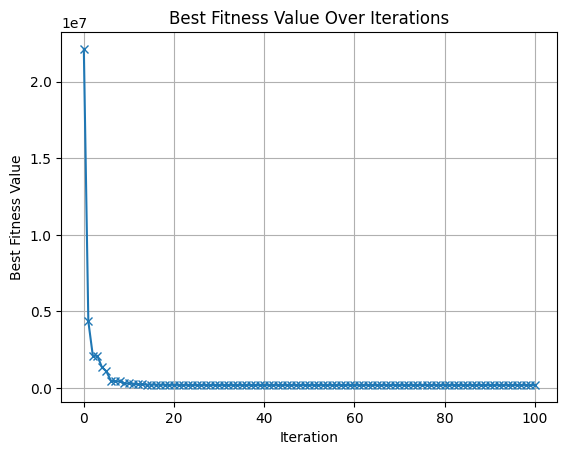

In [ ]:
plt.figure()
plt.plot(range(Max_iter+1), G_best_iters, marker='x', linestyle='-')
plt.title("Best Fitness Value Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness Value")
plt.grid(True)
plt.show()

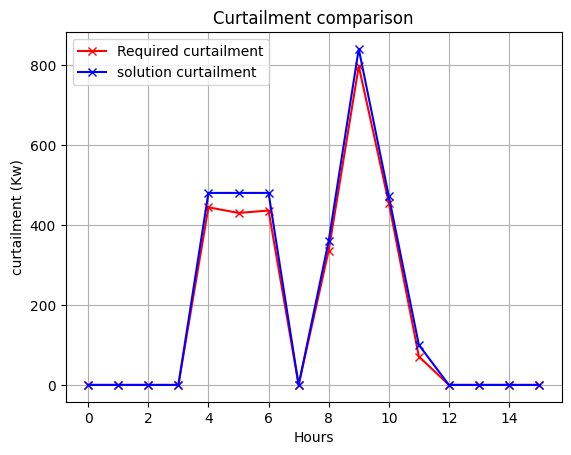

In [ ]:
plt.figure()
plt.plot(curtailment_A, marker='x', linestyle='-', color="r", label="Required curtailment")
plt.plot(G_best_hourly, marker='x', linestyle='-', color="b", label="solution curtailment")
plt.title("Curtailment comparison")
plt.xlabel("Hours")
plt.ylabel("curtailment (Kw)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
off_time = []
for j in range(19):
  IL_off = 0
  for i in range(16):
    IL_off += G_best_x[i][j]

  off_time.append(IL_off)

off_time

[3, 4, 0, 0, 2, 2, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]

In [ ]:
Max_off

array([4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 4, 4])

In [ ]:
on_time = [16-t for t in off_time]
on_time

[13, 12, 16, 16, 14, 14, 16, 16, 15, 16, 16, 15, 15, 16, 16, 15, 15, 15, 16]

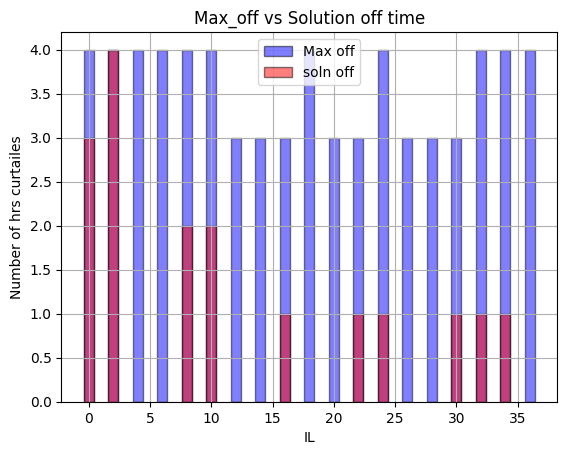

In [ ]:
bin_edges = [2*i for i in range(19)]

plt.bar(bin_edges, Max_off.tolist(), color='blue', alpha = 0.5, edgecolor='black', label='Max off')
plt.bar(bin_edges, off_time, color='red', alpha = 0.5 ,edgecolor='black', label='soln off')

plt.title('Max_off vs Solution off time')
plt.xlabel('IL')
plt.ylabel('Number of hrs curtailes')
plt.legend()
plt.grid(True)

plt.show()

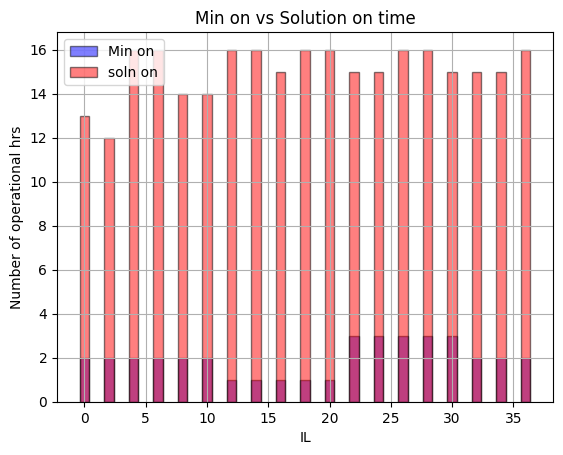

In [ ]:
bin_edges = [2*i for i in range(19)]

plt.bar(bin_edges, Min_on.tolist(), color='blue', alpha = 0.5, edgecolor='black', label='Min on')
plt.bar(bin_edges, on_time, color='red', alpha = 0.5 ,edgecolor='black', label='soln on')

plt.title('Min on vs Solution on time')
plt.xlabel('IL')
plt.ylabel('Number of operational hrs')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
print("----------------------IL priorities and number of times interrupted----------------------")
priority_curtailment_dict = {1:0, 2:0, 3:0}
for i in range(16):
  print(f"\nIL number {i}: priority {priority[i]}: curtailed {np.sum(G_best_x[i])}\n")
  priority_curtailment_dict[priority[i]] += np.sum(G_best_x[i])

----------------------IL priorities and number of times interrupted----------------------

IL number 0: priority 1: curtailed 0


IL number 1: priority 1: curtailed 0


IL number 2: priority 2: curtailed 0


IL number 3: priority 2: curtailed 0


IL number 4: priority 3: curtailed 2


IL number 5: priority 1: curtailed 2


IL number 6: priority 2: curtailed 3


IL number 7: priority 3: curtailed 0


IL number 8: priority 2: curtailed 2


IL number 9: priority 3: curtailed 4


IL number 10: priority 2: curtailed 3


IL number 11: priority 2: curtailed 1


IL number 12: priority 3: curtailed 0


IL number 13: priority 1: curtailed 0


IL number 14: priority 1: curtailed 0


IL number 15: priority 3: curtailed 0



In [ ]:
priority_curtailment_dict

{1: 2, 2: 9, 3: 6}